In [ ]:
!pip install foolbox

In [ ]:
import time, foolbox, torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models

%matplotlib inline


In [ ]:

network = models.inception_v3(pretrained=True)
dataset = 'imagenet'
channels = 3
size = 224
classes = 1000
network.eval();

In [94]:
fnetwork = foolbox.models.PyTorchModel(network, bounds=(0, 1))

images, labels = foolbox.utils.samples(fnetwork,dataset=dataset, batchsize=10, index=11,data_format='channels_first', bounds=(0, 1))
images = images.reshape(10, channels, size, size)

print(images.shape)
print("Labels:      ", labels)
DFpredictions = fnetwork(images).argmax(axis=-1)
print("Predictions: ", DFpredictions)

correct_predictions = (labels == DFpredictions).sum().item()
total_predictions = labels.numel()
accuracy = correct_predictions / total_predictions

print("Model Accuracy "+str(accuracy))

torch.Size([10, 3, 224, 224])
Labels:       tensor([630, 741, 471, 129,  99, 251,  22, 317, 305, 243], device='cuda:0')
Predictions:  tensor([907, 668, 870,  89,  99, 251,  22, 317, 305, 243], device='cuda:0')
Model Accuracy 0.6


In [82]:
attack = foolbox.attacks.LinfDeepFoolAttack()
epsilons = [0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.2, 0.3, 0.4, 0.5]

initial = time.time()
_, DFadvs, success = attack(fnetwork, images, labels, epsilons=epsilons)
after = time.time()

avg = (after-initial)
print("Average Time: ", avg, "seconds")


Average Time:  1.782496690750122 seconds


In [88]:
new = torch.stack(DFadvs)
result_tensor = torch.cat(DFadvs, dim=0)

In [95]:
DFoutput = (fnetwork(result_tensor[:10])).argmax(axis=-1)
print("Predictions: ", DFoutput)

correct_predictions = (labels == DFoutput).sum().item()
total_predictions = labels.numel()
accuracy = correct_predictions / total_predictions

print("DeepFool Attack Accuracy:" + str(accuracy))

Predictions:  tensor([907, 668, 870,  89,  85, 275,  83, 316, 302, 180], device='cuda:0')
DeepFool Attack Accuracy:0.0


In [97]:
attack = foolbox.attacks.L2CarliniWagnerAttack()
epsilons = [0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.2, 0.3, 0.4, 0.5]

initial = time.time()
_, CWadvs, success = attack(fnetwork, images, labels, epsilons=epsilons)
after = time.time()

avg = (after-initial)
print("Average Time for Carlini Wagner: ", avg, "seconds")


Average Time for Carlini Wagner:  1004.8188509941101 seconds


In [98]:
new = torch.stack(CWadvs)
result_tensor = torch.cat(CWadvs, dim=0)

In [100]:
CWoutput = (fnetwork(result_tensor[:10])).argmax(axis=-1)
print("Predictions: ", CWoutput)

correct_predictions = (labels == CWoutput).sum().item()
total_predictions = labels.numel()
accuracy = correct_predictions / total_predictions

print("Carlini Wagner Attack Accuracy:" + str(accuracy))

Predictions:  tensor([907, 668, 870,  89,  99, 251,  22, 317, 305, 243], device='cuda:0')
Carlini Wagner Attack Accuracy:0.6


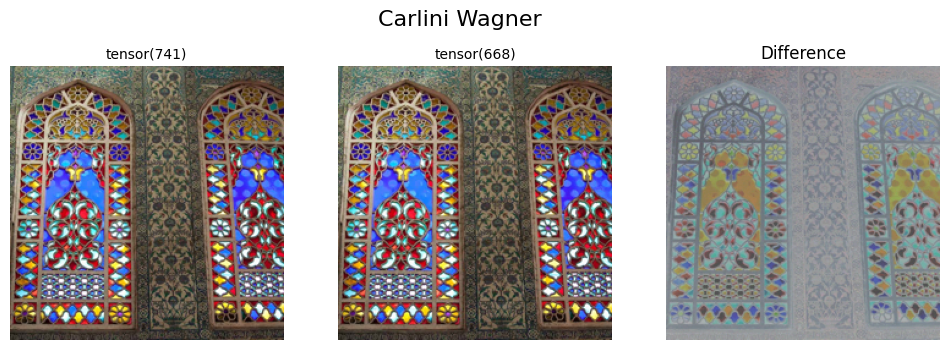

<ipython-input-107-058e2797ff61>:48: RuntimeWarning: invalid value encountered in divide
  axs[2].imshow(difference / abs(difference).max() * 0.2 + 0.5)


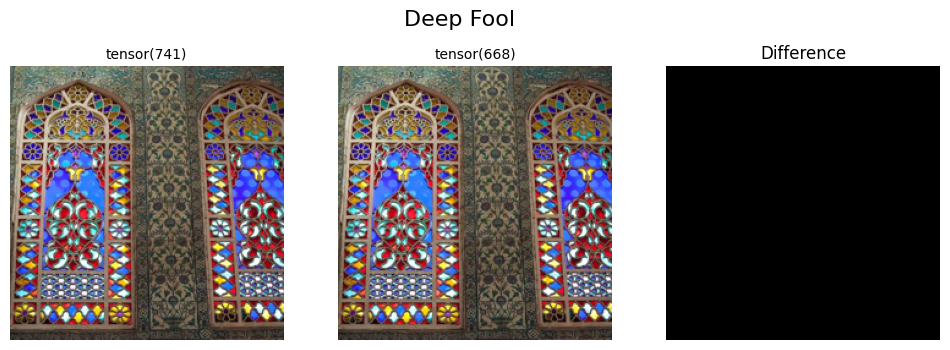

In [107]:
adversarialCW = CWadvs[0][1]
adversarialDF = DFadvs[0][1]

current_image = images[1]

image_np = current_image.cpu().numpy()
image_np = image_np.transpose(1, 2, 0)

adversarialCW_np = adversarialCW.cpu().numpy()
adversarialCW_np = adversarialCW_np.transpose(1, 2, 0)


adversarialDF_np = adversarialDF.cpu().numpy()
adversarialDF_np = adversarialDF_np.transpose(1, 2, 0)


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(image_np)
axs[0].set_title(str(labels[1].cpu()), fontsize=10)
axs[0].axis('off')

axs[1].imshow(adversarialCW_np)
axs[1].set_title(str(CWoutput[1].cpu()), fontsize=10)
axs[1].axis('off')

difference = adversarialCW_np - image_np
axs[2].imshow(difference / abs(difference).max() * 0.2 + 0.5)
axs[2].set_title('Difference')
axs[2].axis('off')

fig.suptitle('Carlini Wagner', fontsize=16)

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(image_np)
axs[0].set_title(str(labels[1].cpu()), fontsize=10)
axs[0].axis('off')

axs[1].imshow(adversarialDF_np)
axs[1].set_title(str(DFoutput[1].cpu()), fontsize=10)
axs[1].axis('off')

difference = adversarialDF_np - image_np
axs[2].imshow(difference / abs(difference).max() * 0.2 + 0.5)
axs[2].set_title('Difference')
axs[2].axis('off')

fig.suptitle('Deep Fool', fontsize=16)

plt.show()
